In [40]:
# %%file strategy_4.py

import import_ipynb
from strategy_base import TradeStrategyBase

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

class TradeStrategy4(TradeStrategyBase):
    """
    Trade Strategy 4: Slope and Velocity.
    Overview:
    Use close price to draw a trend, use the derivative to find the slope.
    Use the derivative again to find the velocity for change.
    
    When price raises rapidly, slope > 0, velocity > 0
    When price raises becomes slowly, slope > 0, velocity close 0
    When price peaks, slope = 0, 
    When price falls rapidly, slope < 0, velocity > 0
    When price falls slowly, slope < 0, velocity close to 0 
    When price bottoms, slope = 0,
    
    Therefore, we can use a slope and velocity to find trends and make trades.
    
    Long when price is rising (slope > _buy_slope_threshold > 0) & accelerating (velocity > _buy_velocity_threshold > 0) & Close when price starting to fall (slope < -_close_slope_threshold < 0 and velocity < -_close_velocity_threshold < 0)
    Short when price is falling (slope < _sell_slope_threshold < 0) & accelerating (velocity < _sell_velocity_threshold < 0) & Close when price starting to fall (slope > _close_slope_threshold > 0 and velocity > _close_velocity_threshold > 0)
    
    Assumptions: 
    
    Requirement: 
    1. This strategy should work with any highly liquid security. Preferably Forex or Crypto.
    2. This strategy should work whether trend is up or down, volatile or not. 
    3. The more volatile, the better, as we need to quickly close the position after mean reversion, BEFORE moving_average moved too much. 
    Constants: 
    Params:
    _buy_slope_threshold:       # The slope required to trigger BUY
    _buy_velocity_threshold:    # The velocity required to trigger BUY
    _close_slope_threshold:     # The slope required to trigger CLOSE
    _close_velocity_threshold:  # The slope required to trigger CLOSE
    _sell_slope_threshold:      # The slope required to trigger SELL
    _sell_velocity_threshold:   # The velocity required to trigger SELL
    """
    _buy_slope_threshold = 0.1
    _buy_velocity_threshold = 0.1
    _close_slope_threshold = 0.1
    _close_velocity_threshold = 0.1
    _sell_slope_threshold = -0.1
    _sell_velocity_threshold = -0.1
    
    def __init__(self, buy_slope_threshold:float = 0.1, buy_velocity_threshold:float = 0.1, close_slope_threshold:float = 0.1, close_velocity_threshold:float = 0.1, sell_slope_threshold:float = -0.1, sell_velocity_threshold:float =- 0.1, should_log:bool = False, should_plot:bool = False, axs = None):
        """
        Initialize Strategy with given parameters
        :type buy_slope_threshold: float
        :type buy_velocity_threshold: float 
        :type close_slope_threshold: float
        :type close_velocity_threshold: float 
        :type sell_slope_threshold: float
        :type sell_velocity_threshold: float  
        :type should_log: bool
        :type should_plot: bool
        :param buy_slope_threshold: # The slope required to trigger BUY
        :param buy_velocity_threshold: # The velocity required to trigger BUY 
        :param close_slope_threshold: # The slope required to trigger CLOSE
        :param close_velocity_threshold: # The slope required to trigger CLOSE 
        :param sell_slope_threshold: # The slope required to trigger SELL
        :param sell_velocity_threshold: # The velocity required to trigger SELL 
        :param should_log Whether or not log the strategy
        :param should_plot Whether or not plot the strategy
        """
        self._buy_slope_threshold = buy_slope_threshold
        self._buy_velocity_threshold = buy_velocity_threshold
        self._close_slope_threshold = close_slope_threshold
        self._close_velocity_threshold = close_velocity_threshold
        self._sell_slope_threshold = sell_slope_threshold
        self._sell_velocity_threshold = sell_velocity_threshold
        self._should_log = should_log
        self._should_plot = should_plot
        self._axs = axs
        
        self._position = 0
        self._long_tradedays =  pd.DataFrame()
        self._short_tradedays = pd.DataFrame()
        
    def trade(self, date:pd.Timestamp, tradeday: pd.Series):
        """
        Perform Analysis, Decide on Trade, and Execute Trade
        :type date: pd.Timestamp
        :type tradeday: pd.Series
        :param date: The pandas DataFrame date
        :param tradeday: The pandas DateFrame Series representing a trade day
        :return: 
        """
        
        """
        Validate Data, Check tradeday has column 'ma_x' & 'mov_std_x' & 'ewm_std_x'.
        """
        if not hasattr(tradeday, 'slope'):
            # Data Incomplete, do not trade
            return
            
        """
        Firstly, add tradeday to position DataFrame
        """
        if self._position == 1:
            # Add Long days to _long_tradedays
            self._long_tradedays = self._long_tradedays.append(tradeday)
        elif self._position == -1:
            # Add Short days to _short_tradedays
            self._short_tradedays = self._long_tradedays.append(tradeday)
        
        """
        Secondly, Closing
        """
        if self._evaluate_closing(date=date,
                                 tradeday=tradeday):
            self._execute_closing(date=date,
                                 tradeday=tradeday)
        
        """
        Thirdly, Buying
        """
        if self._evaluate_buying(date=date,
                                 tradeday=tradeday):
            self._execute_buying(date=date,
                                 tradeday=tradeday)
        
        """
        Finally, Selling
        """
        if self._evaluate_selling(date=date,
                                  tradeday=tradeday):
            self._execute_selling(date=date,
                                  tradeday=tradeday)
        
        
    def _evaluate_closing(self, date:pd.Timestamp, tradeday: pd.Series):
        """
        Evaluate whether or not BUY should be executed
        :type date: pd.Timestamp
        :type tradeday: pd.Series
        :param date: The pandas DataFrame date
        :param tradeday: The pandas DateFrame Series representing a trade day
        """
        slope = tradeday["slope"]
        velocity = tradeday["velocity"]
        
        if self._position == -1:
            # Currently have short position
            if slope > self._close_slope_threshold and velocity > self._close_velocity_threshold:
                # Slope & Velocity Reverted
                return True
        elif self._position == 1:
            # Currently have long position
            if slope < -self._close_slope_threshold and velocity < -self._close_velocity_threshold:
                # Slope & Velocity Reverted
                return True
        return False
        
    def _execute_closing(self, date:pd.Timestamp, tradeday: pd.Series):
        """
        How BUY should be executed
        :type date: pd.Timestamp
        :type tradeday: pd.Series
        :param date: The pandas DataFrame date
        :param tradeday: The pandas DateFrame Series representing a trade day
        """
        if self._should_log:
            print("- Closed on {} at ${}.".format(date, tradeday.close))
        self._position = 0
        
        
    def _evaluate_buying(self, date:pd.Timestamp, tradeday: pd.Series):
        """
        Evaluate whether or not BUY should be executed
        :type date: pd.Timestamp
        :type tradeday: pd.Series
        :param date: The pandas DataFrame date
        :param tradeday: The pandas DateFrame Series representing a trade day
        """
        slope = tradeday["slope"]
        velocity = tradeday["velocity"]
        
        if slope > self._buy_slope_threshold and velocity > self._buy_velocity_threshold:
            # When Slope & Velocity is above threshold
            if self._position == 0:
                return True
        return False
        
    def _execute_buying(self, date:pd.Timestamp, tradeday: pd.Series):
        """
        How BUY should be executed
        :type date: pd.Timestamp
        :type tradeday: pd.Series
        :param date: The pandas DataFrame date
        :param tradeday: The pandas DateFrame Series representing a trade day
        """
        if self._should_log:
            print("Bought on {} at ${}.".format(date, tradeday.close))
        self._long_tradedays = self._long_tradedays.append(tradeday)
        self._position = 1

    def _evaluate_selling(self, date:pd.Timestamp, tradeday: pd.Series):
        """
        Evaluate whether or not SELL should be executed
        :type date: pd.Timestamp
        :type tradeday: pd.Series
        :param date: The pandas DataFrame date
        :param tradeday: The pandas DateFrame Series representing a trade day
        """
        slope = tradeday["slope"]
        velocity = tradeday["velocity"]
        
        if slope < self._sell_slope_threshold and velocity < self._sell_velocity_threshold:
            # When Slope & Velocity is above threshold
            if self._position == 0:
                return True
        return False
            
    def _execute_selling(self, date:pd.Timestamp, tradeday: pd.Series):
        """
        How SELL should be executed
        :type date: pd.Timestamp
        :type tradeday: pd.Series
        :param date: The pandas DataFrame date
        :param tradeday: The pandas DateFrame Series representing a trade day
        """
        if self._should_log:
            print("Sold on {} at ${}.".format(date, tradeday.close))
        if self._should_plot:
            self._plot_trade(axs=self._axs,
                             buy_date=self._last_buy_date, 
                             sell_date=date)
        self._short_tradedays = self._short_tradedays.append(tradeday)
        self._position = -1

    def _plot_trade(self, axs, buy_date, sell_date):

        print("Todo: Plotting {} {}".format(buy_date, sell_date))

        # buy_tradeday = self._held_tradedays[buy_date.date()]
        # sell_tradeday = self._held_tradedays[sell_date.date()]
        # print("Bought at {}, Sold at {}".format(buy_tradeday.close, sell_tradeday.close))

        # drawer = plt if axs is None else axs
        # 
        # # Mark red for up and green for down, slicing using start and end
        # if sell_tradeday.close < buy_tradeday.close:
        #   drawer.fill_between(self._held_tradedays.index[buy_date:sell_date], 0,
        #                   self._held_tradedays['close'][buy_date:sell_date], color='red',
        #                   alpha=.38)
        #   is_win = False
        # else:
        #   drawer.fill_between(amex_df.index[buy_date:sell_date], 0,
        #                   amex_df['close'][buy_date:sell_date], color='green',
        #                   alpha=.38)
        #   is_win = True
        # 
        # return is_win
        
    @property
    def trade_profit(self):
        long_profit = 0.0
        if 'p_change' in self._long_tradedays.columns:
            profit_array = self._long_tradedays.p_change/100 + 1
            long_profit = np.product(profit_array) - 1
        short_profit = 0.0
        if 'p_change' in self._short_tradedays.columns:
            profit_array = self._short_tradedays.p_change/100 - 1
            short_profit = np.abs(np.product(profit_array)) - 1
        return long_profit + short_profit
    
    @property
    def p_change_threshold(self):
        return self._p_change_threshold
    
    @property
    def keep_stock_threshold(self):
        return self._hold_stock_threshold
    

Sold on 2017-06-21 00:00:00 at $82.21.
- Closed on 2017-06-22 00:00:00 at $82.28.
Sold on 2017-06-29 00:00:00 at $83.63.
- Closed on 2017-06-30 00:00:00 at $84.24.
Sold on 2017-07-05 00:00:00 at $84.89.
- Closed on 2017-07-07 00:00:00 at $84.33.
Bought on 2017-07-20 00:00:00 at $85.35.
- Closed on 2017-07-24 00:00:00 at $85.0.
Bought on 2017-07-28 00:00:00 at $84.8.
- Closed on 2017-08-10 00:00:00 at $84.56.
Sold on 2017-08-25 00:00:00 at $85.47.
- Closed on 2017-08-28 00:00:00 at $85.41.
Sold on 2017-08-28 00:00:00 at $85.41.
- Closed on 2017-08-29 00:00:00 at $85.42.
Bought on 2017-08-29 00:00:00 at $85.42.
- Closed on 2017-09-05 00:00:00 at $85.31.
Sold on 2017-09-20 00:00:00 at $88.43.
- Closed on 2017-09-21 00:00:00 at $88.44.
Sold on 2017-09-27 00:00:00 at $89.5.
- Closed on 2017-09-28 00:00:00 at $90.14.
Sold on 2017-10-04 00:00:00 at $90.99.
- Closed on 2017-10-05 00:00:00 at $91.16.
Sold on 2017-10-16 00:00:00 at $91.96.
- Closed on 2017-10-18 00:00:00 at $92.03.
Bought on 201

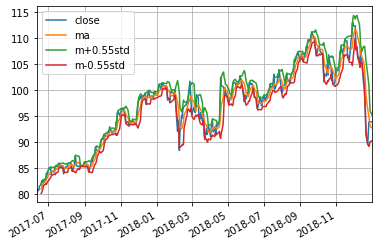